![](pics/TEG.png)
![](pics/TEG_1.png)
![](pics/TEG_2.png)
![](pics/TEG_3.png)
![](pics/TEG_4.png)
![](pics/TEG_5.png)
![](pics/TEG_6.png)
![](pics/TEG_7.png)
![](pics/TEG_8.png)

> Click [here](https://github.com/i9k/teg-movie-presentation) to see the codes

In [1]:
import pandas as pd  
import matplotlib as mpl
import matplotlib.pyplot as plt

# https://stanford.edu/~mwaskom/software/seaborn/index.html
import seaborn as sns

import numpy as np  # to use certain functions

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score
from sklearn import linear_model # to use linear classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel

# deep learning! we will use tensorflow learn
import tensorflow as tf
from tensorflow.contrib import learn

# we want to see plots right in notebook
%matplotlib inline  
# styling
sns.set_style("dark")
mpl.style.use('ggplot')

Read the data from a .CSV fie and check the types

In [2]:
df = pd.read_csv("data/movie_metadata_upd_final.csv")
df = df.sample(frac=1).reset_index(drop=True)
NROWS = df.shape[0]
print("this database contains {} variables and {} rows".format(df.shape[1], NROWS))
df.head()

this database contains 42 variables and 4353 rows


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,tagline_pct_nouns,tagline_pct_adj,pct_action_fantasy,plot_complexity,rel_weekday,rel_quarter,director_sex,actor_1_sex,actor_2_sex,actor_3_sex
0,Color,Ang Lee,210.0,120.0,0.0,210.0,Kevin Chamberlin,579.0,7443007.0,Comedy|Drama|Music,...,11.1,11.1,0.0,15,3.0,3.0,M,F,M,M
1,Color,Shawn Levy,97.0,95.0,189.0,306.0,David Agranov,500.0,56127162.0,Comedy|Romance,...,28.6,0.0,0.0,5,3.0,1.0,M,M,M,M
2,Color,Mark Brown,14.0,90.0,7.0,424.0,Monica Calhoun,890.0,92362.0,Comedy|Drama,...,20.0,10.0,0.0,1,NaN,NaN,M,M,F,M
3,Color,Noam Murro,366.0,102.0,263.0,1000.0,Sullivan Stapleton,6000.0,106369117.0,Action|Drama|Fantasy|War,...,33.3,33.3,50.0,7,3.0,1.0,M,F,M,M
4,Color,James L. Brooks,168.0,121.0,274.0,157.0,Domenick Lombardozzi,273.0,30212620.0,Comedy|Drama|Romance,...,NaN,NaN,0.0,8,3.0,1.0,M,M,M,M


Let's see what types are there:

In [3]:
df.dtypes

color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
m

## Handling missing values

Let us see how many missing values are there for each variable (will be shown with a minus)

In [4]:
df.count()-NROWS

color                        -14
director_name                  0
num_critic_for_reviews       -40
duration                     -12
director_facebook_likes        0
actor_3_facebook_likes       -16
actor_2_name                 -10
actor_1_facebook_likes        -7
gross                       -545
genres                         0
actor_1_name                  -7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                 -16
facenumber_in_poster         -13
plot_keywords               -139
movie_imdb_link                0
num_user_for_reviews         -15
language                      -5
country                       -1
content_rating              -252
budget                      -367
title_year                     0
actor_2_facebook_likes       -10
imdb_score                     0
aspect_ratio                -296
movie_facebook_likes           0
rel_date                     -53
tagline                     -655
tagline_pc

Here is a reasonable fix:
> **color**: fill with "Color" because these days nearly movies are shot in color (and we only consider movies released since 1991)  
> **num_critic_for_reviews**: perhaps, there were no reviews; set missing values to zero  
> **num_user_for_reviews**: as above
> **duration**: take the avrage duration across all movies  
> **actor_3_facebook_likes**: for now, assume it's possible that no FB user likes this actor - set zero  
> **actor_1_facebook_likes**: similar to the above  
> **actor_2_facebook_likes**: as above  
> **actor_2_name**: this is interesting; make it "Unknown Actor" because we don't really care (for the purposes of this project)  
> **actor_1_name**: similar to the above  
> **actor_3_name**: similar to the above  
> **gross**: this is a bit troubling, that so many groww figures are missing; anyway, set them to zero as there doesn't seem to be any more sensible solution right now  
> **facenumber_in_poster**: it is very much possible that there can be no faces in posters, so set to zero  
> **plot_keywords**: let's just add the word "missing"; surely, there are other a bit more complex solutions like to infer topic from the movie title or look it up on Wikipedia or something else  
> **language**: could be easily looked up; to save time, make it "unknown"  
> **country**: as above  
> **content_rating**: as above  
> **budget**: many missing figures! would normally find out (news, Wikipedia, etc.) but now set to the average budget  
> **aspect_ratio**: set to the most popular one  
> **rel_date**: have to be careful here; say, it's 01 January of that year  
> **tagline**: just "missing"  
> **tagline_pct_verbs**: zero  
> **tagline_pct_punkt**: as above  
> **tagline_pct_nouns**: as above  
> **tagline_pct_adj**: as above  
> **rel_weekday**: take the average across all available weekdays  
> **rel_quarter**: as above


In [5]:
df["color"] = df["color"].fillna("Color")
df["num_critic_for_reviews"] = df["num_critic_for_reviews"].fillna(0)
df["duration"] = df["duration"].fillna(df["duration"].mean())
df["actor_3_facebook_likes"] = df["actor_3_facebook_likes"].fillna(0)
df["actor_1_facebook_likes"] = df["actor_1_facebook_likes"].fillna(0)
df["actor_2_name"] = df["actor_2_name"].fillna("Unknown Actor")
df["actor_1_name"] = df["actor_1_name"].fillna("Unknown Actor")
df["actor_3_name"] = df["actor_3_name"].fillna("Unknown Actor")
df["gross"] = df["gross"].fillna(0)
df["facenumber_in_poster"] = df["facenumber_in_poster"].fillna(0)
df["plot_keywords"] = df["plot_keywords"].fillna("missing")
df["num_user_for_reviews"] = df["num_user_for_reviews"].fillna(0)
df["language"] = df["language"].fillna("unknown")
df["country"] = df["country"].fillna("unknown")
df["content_rating"] = df["content_rating"].fillna("unknown")
df["budget"] = df["budget"].fillna(df["budget"].mean())
df["actor_2_facebook_likes"] = df["actor_2_facebook_likes"].fillna(0)
df["aspect_ratio"] = df["aspect_ratio"].fillna(df["aspect_ratio"].mode().iloc[0])
df["rel_date"] = df["rel_date"].fillna(pd.to_datetime(df["title_year"]))  
df["tagline"] = df["tagline"].fillna("missing")
df["tagline_pct_verbs"] = df["tagline_pct_verbs"].fillna(0)
df["tagline_pct_punkt"] = df["tagline_pct_punkt"].fillna(0)
df["tagline_pct_nouns"] = df["tagline_pct_nouns"].fillna(0)
df["tagline_pct_adj"] = df["tagline_pct_adj"].fillna(0)
df["rel_weekday"] = df["rel_weekday"].fillna(df["rel_weekday"].mode().iloc[0])
df["rel_quarter"] = df["rel_quarter"].fillna(df["rel_quarter"].mode().iloc[0])

Add a new variable **profitability**, which will be defined by a profitability function as follows  
> f(movie): 1 if gross/budget > 1 (profitable) or 0 (flop) otherwise. 

In [6]:
df["profitability"] = df["gross"].divide(df["budget"], fill_value=0).apply(lambda _: 1 if _ > 1 else 0)

## Data Exploration and Sanity Check

This section can be HUGE. Here, we only show a few plots.

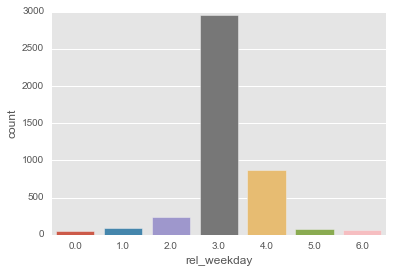

In [7]:
sns.countplot(x="rel_weekday", data=df)

> _Wednesday_ is by far the most popular release day. 

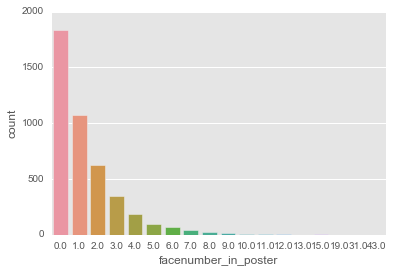

In [8]:
sns.countplot(x="facenumber_in_poster", data=df)

> More often than not, there are _no faces_ in movie posters. Really? Recall that we had many missing values for this feature. Apart from that, a single face in a poster occurs twice as often as two faces. Sounds plausible..

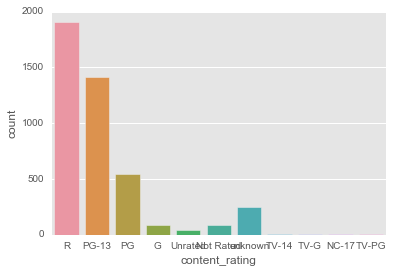

In [9]:
sns.countplot(x="content_rating", data=df)

> So the majotiry of movies are R-rated (invididuals under the age of 17 advised to watch these movies with adult accompaniment).

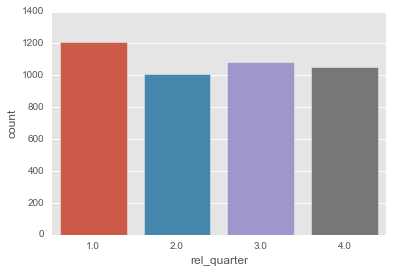

In [10]:
sns.countplot(x="rel_quarter", data=df)

> Movies get released more or less equally frequently each quarter. However, the first quarter (starting January) is the most popular.

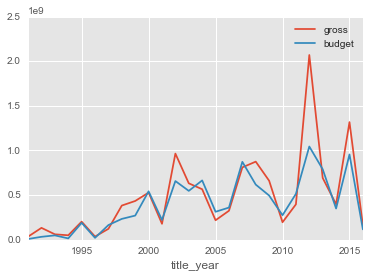

In [11]:
df[df["director_sex"]=="F"].groupby("title_year").sum()[["gross","budget"]].plot()


> Generally speaking, the larger the budget the higher gross can be expected. 

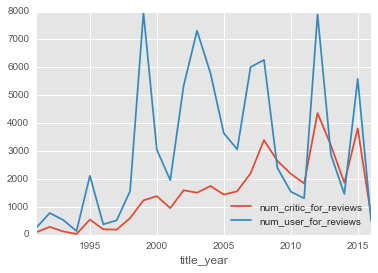

In [12]:
df[df["director_sex"]=="F"].groupby("title_year").sum()[["num_critic_for_reviews","num_user_for_reviews"]].plot()

> Here we only look at the female directed movies. Sometimes, critics are much more interested in reviewing movies than IMDB users? Although, the situation when users don't care to review but critics do very much are rare. **Need to specify what the reviews are an indication of exactly.**

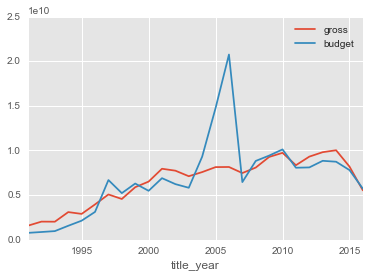

In [13]:
df[df["director_sex"]=="M"].groupby("title_year").sum()[["gross","budget"]].plot()


> Consider only the male directed movies. See what happened around 2005!

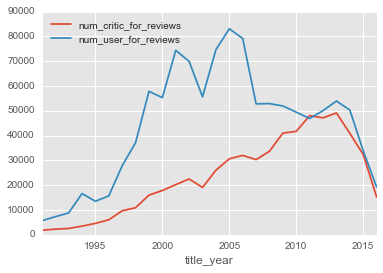

In [14]:
df[df["director_sex"]=="M"].groupby("title_year").sum()[["num_critic_for_reviews","num_user_for_reviews"]].plot()

> Again, male directed movies. Clearly, the question is what this might mean.

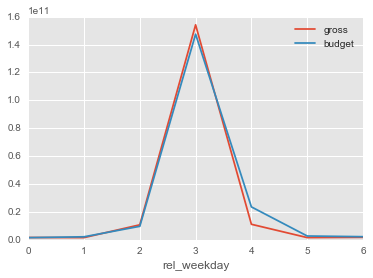

In [15]:
df.groupby("rel_weekday").sum()[["gross","budget"]].plot()

> Look at the movies released on Thursday: do potential flops tend to get shifted to Thursday release?

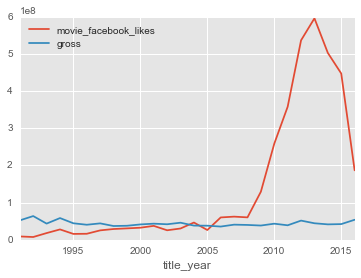

In [16]:
df.groupby("title_year").agg({"gross": np.mean, "movie_facebook_likes": lambda x: 100*sum(x)}).plot()

> It helps to know that Facebook started in 2004. Most interesting...

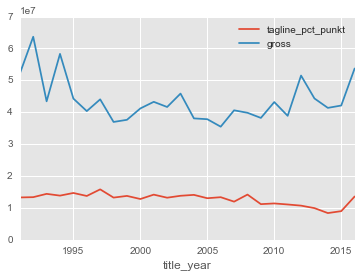

In [17]:
df.groupby("title_year").agg({"gross": np.mean, "tagline_pct_punkt": lambda x: 1000000*np.mean(x)}).plot()

> This relates to the question whether sticking more punktuation in taglines makes any difference. Surely, something to discuss as the idea doesn't seem hopeless.

Back to sanity check mentioned in the section title. Here is a good example:  
> some movies from our dataset grossed **140 times their budget**. This may need additional verification.

## Prediction

Recall that we want to predict **success** of a potential movie. And the measure of success is how **profitable** it is. Therefore, we are predicting **profitability** introduced earlier (profitable is 1 and flop is 0). This is a simple case for applying _binary classifiers_.

#### Specifying features and converting categorical features to numerical

In [18]:
# these are the features (variables) we feel could be important to use for prediction
vars_for_prediction = ["num_critic_for_reviews","num_user_for_reviews",
                       "duration","director_facebook_likes","budget",
                       "rel_quarter","director_sex","plot_complexity",
                      "tagline_pct_verbs","tagline_pct_adj","pct_action_fantasy","rel_weekday",
                      "actor_1_sex","facenumber_in_poster"]

# note that we have the sex features as "M" or "F"; we need to make these numerical
vec = DictVectorizer(sparse=False)  # this vectoriser os from scikit-learn

# DictVectorizer expects data as a list of dictionaries, where each dictionary is a data 
# row with column names as keys; for example, 
# [ { 'director': 'M', 'budget': 25 }, { 'director': 'F', 'budget': 259 }, ...]

df_var = df[vars_for_prediction]
df_var_as_dict = df_var.T.to_dict().values()
df_var_vectorized_as_array = vec.fit_transform(df_var_as_dict)  # returns an numpy array
df_var_vectorized = pd.DataFrame(df_var_vectorized_as_array) 

# vec.get_feature_names() 

#### Create the training and testing sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    df_var_vectorized, df["profitability"], test_size=0.2, random_state=13)

### Logistic Regression

In [20]:
lreg = linear_model.LogisticRegression()
lreg.fit(X_train, y_train)
print("Logistic prediction accuracy: {}".format(round(accuracy_score(y_test, lreg.predict(X_test)),3)))

Logistic prediction accuracy: 0.592


### Naive Bayes

In [21]:
nb = GaussianNB()
nb.fit(X_train, y_train)
print("Naive Bayes prediction accuracy: {}".format(round(accuracy_score(y_test, nb.predict(X_test)),3)))

Naive Bayes prediction accuracy: 0.411


### SVM (C-Support Vector Classification)

In [22]:
sv = SVC()
sv.fit(X_train, y_train)
print("SMV prediction accuracy: {}".format(round(accuracy_score(y_test, sv.predict(X_test)),3)))

SMV prediction accuracy: 0.605


### Neural Networks (TensorFlow)

In [23]:
tf.logging.set_verbosity(tf.logging.FATAL)
tfc = learn.LinearClassifier(n_classes=2, feature_columns=learn.infer_real_valued_columns_from_input(X_train), optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.05))
tfc.fit(X_train, y_train, batch_size=14, steps=500)
print("TensorFlow prediction accuracy: {}".format(round(accuracy_score(y_test, tfc.predict(X_test)),3)))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py:1811: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  result_shape.insert(dim, 1)


TensorFlow prediction accuracy: 0.592


### Random Forests

In [24]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print("Random Forests prediction accuracy: {}".format(round(accuracy_score(y_test, rf.predict(X_test)),3)))


Random Forests prediction accuracy: 0.695


#### Model-based feature selection

Because Random Forests is our best model, we may want to use it to see if it would make sense to get rid of some features that are of questionable value. This is more useful when the number of features is a lot larger than we have now.

In [25]:
model = SelectFromModel(rf, prefit=True)  # selecting features based on importance weights
X_train_new = model.transform(X_train)  # transform(X) reduce X to the selected features
print("Good news from Feature Selection! We can do with {} features instead of {}!".format(X_train_new.shape[1], X_train.shape[1]))


Good news from Feature Selection! We can do with 6 features instead of 16!


In [26]:
# let's look at the feature weights (in %):
for n, im in zip(vec.get_feature_names(), rf.feature_importances_):
    print(n,100*round(im,4))

actor_1_sex=F 0.99
actor_1_sex=M 0.9
budget 10.94
director_facebook_likes 9.31
director_sex=F 0.65
director_sex=M 0.4
duration 9.02
facenumber_in_poster 4.31
num_critic_for_reviews 15.44
num_user_for_reviews 20.58
pct_action_fantasy 3.24
plot_complexity 6.01
rel_quarter 3.23
rel_weekday 3.59
tagline_pct_adj 4.91
tagline_pct_verbs 6.48


## Demonstration of the Product and Bonus Insights

Is this project called **our_project** going to be successful? Well, accoring to our model..

In [27]:
our_project = pd.DataFrame.from_dict({"actor_1_sex=F": [1],
"actor_1_sex=M": [0],
"budget": [5000000],
"director_facebook_likes": [20000],   # change 20000 to 150 to see how we predict a flop
"director_sex=F": [1],"director_sex=M": [0],
"duration": [131],
"facenumber_in_poster": [4],
"num_critic_for_reviews": [93],
"num_user_for_reviews": [321],
"pct_action_fantasy": [20],
"plot_complexity": [30],
"rel_quarter": [2],
"rel_weekday": [3],
"tagline_pct_adj": [25],
"tagline_pct_verbs": [50]})

In [28]:
#### What is our model thinking about this project? 

In [29]:
predicted_success = rf.predict(our_project)[0]
msg_for_client = "".join(["An instant blockbuster!" if predicted_success == 1 else
                          "Looks like a flop. Think about revising your project. Increase the budget or something.."])
print(msg_for_client)

Looks like a flop. Think about revising your project. Increase the budget or something..


Finally, some **insights** based on this dataset:
* consider scheduling the movie release on Wednesday
* it doesn't seem to matter for a movie success if the director is male or female, so no need to worry about that (under our model)
* taglines (specifically, what you put in them) as well as posters are worth attention; a more in-depth investigation is needed to provide detailed recommendations